# Notebook 6b - Finding cloud frequency using spectral thresholds

Using Notebook 5 (tsi_goes_comparison), we have found a combination of thresholds using a decision tree to identify cloudy vs. clear pixels in GOES data using Total Sky Imager data from the East River, Colorado.

In [1]:
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
from matplotlib.colors import LightSource
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# from analysis_utils import daily_cloud_frequency, process_monthly_data

/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


## Calculate cloud frequency and sum monthly

In [2]:
def daily_cloud_frequency(year, month, state, goes):
    '''
    Function to calculate daily cloud frequency from GOES RGB composite data

    Parameters
    ----------
    year : str
        e.g., '2022'
    month : str
        e.g., '07' for July
    state : str
        e.g., 'washington'
    goes : str
        e.g., 'goes16' or 'goes17'
    '''

    # define day ranges to loop through
    start_day = 1
    if month in ['01', '03', '05', '07', '08', '10', '12']:
        end_day = 32
    elif month in ['04', '06', '09', '11']:
        end_day = 31
    elif month == '02':
        end_day = 29
    
    # Initialize an empty list to store daily datasets
    monthly_ds_list = []

    for day in range(start_day, end_day):    
        date = f'{year}{month}' + str(day).zfill(2)
        path = f'/storage/cdalden/goes/{state}/{goes}/rgb_composite/'
        file = f'{goes}_C02_C05_C13_rgb_{state}_{date}.nc'.format(date=date)

        ds = xr.open_dataset(path + file)

        # Make mask for cloud/no cloud
        if month == '07' or month == '08':
            cloud_mask = (ds.red >= 0.07) & (ds.green >= 0.19) # summer mask
        elif month == '04' or month == '05':
            cloud_mask = (ds.blue > 0.15) & (ds.red > 0.22) # spring mask        
        elif month == '01' or month == '02':
            cloud_mask = (ds.blue >= 0.13) & (ds.red > 0.39) # winter mask

        clouds = xr.where(cloud_mask, 1, 0) # cloud (1) if all conds are met, not cloud (0) otherwise
        ds['clouds'] = clouds

        # Select the time range between 6am and 9pm MDT/7am and 10pm MST
        ds = ds.clouds.sel(
            t=((ds['t'].dt.hour >= 0) & (ds['t'].dt.hour < 3)) | (ds['t'].dt.hour >= 12)
        )                                                         # removed sum function here

        # Append the daily dataset to the list
        monthly_ds_list.append(ds)

        print(f'appended for {date}')

    # Concatenate all daily datasets along the time dimension
    monthly_ds = xr.concat(monthly_ds_list, dim='t')
    print('done with concatenation')
    
    # Save the concatenated dataset to a NetCDF file
    out_path = f'/storage/cdalden/goes/{state}/{goes}/cloud_counts/'
    out_file = f'{goes}_cloud_frequency_{state}_{year}{month}.nc'
    monthly_ds.to_netcdf(out_path + out_file)


### Run the functions

In [3]:
year = '2023'
state = 'colorado'
goes = 'goes16'
# months_list = ['06', '07', '08', '09']
months_list = ['02']
for month in months_list:
    daily_cloud_frequency(year,month, state, goes)

appended for 20230201
appended for 20230202
appended for 20230203
appended for 20230204
appended for 20230205
appended for 20230206
appended for 20230207
appended for 20230208
appended for 20230209
appended for 20230210
appended for 20230211
appended for 20230212
appended for 20230213
appended for 20230214
appended for 20230215
appended for 20230216
appended for 20230217
appended for 20230218
appended for 20230219
appended for 20230220
appended for 20230221
appended for 20230222
appended for 20230223
appended for 20230224
appended for 20230225
appended for 20230226
appended for 20230227
appended for 20230228
done with concatenation


In [10]:
# Define the months and their corresponding variable names
months_dict = {'06': 'jun_cloud_freq', '07': 'jul_cloud_freq', 
               '08': 'aug_cloud_freq', '09': 'sep_cloud_freq'}
# Dictionary to store the datasets
cloud_freq_datasets = {}

# Loop through the months and process the data
for month, var_name in months_dict.items():
    ds = process_monthly_data(year, month, state, goes, save_file=True)  # Process the data for the month
    cloud_freq_datasets[var_name] = ds  # Save the dataset with the variable name as the key

# Access the datasets
jun_cloud_freq = cloud_freq_datasets['jun_cloud_freq']
jul_cloud_freq = cloud_freq_datasets['jul_cloud_freq']
aug_cloud_freq = cloud_freq_datasets['aug_cloud_freq']
sep_cloud_freq = cloud_freq_datasets['sep_cloud_freq']


Saved monthly cloud frequency data for month 06
Saved monthly cloud frequency data for month 07
Saved monthly cloud frequency data for month 08
Saved monthly cloud frequency data for month 09


In [11]:
# sep_minus_aug = sep_cloud_freq['monthly_frequency'] - aug_cloud_freq['monthly_frequency']
aug_minus_jul = aug_cloud_freq['monthly_frequency'] - jul_cloud_freq['monthly_frequency']

## Plots

In [7]:
# Path to the DEM file
dem_path = "nasa_colorado_dem.tif"

# Open the DEM file
with rasterio.open(dem_path) as src:
    elevation = src.read(1)  # Read the first band (elevation data)
    bounds = src.bounds      # Get the bounds of the DEM
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]


# subset DEM for East River
bbox = [-107.4, -106.7, 38.7, 39.3]
with rasterio.open(dem_path) as src:
    window = rasterio.windows.from_bounds(bbox[0], bbox[2], bbox[1], bbox[3], transform=src.transform)
    er_elevation = src.read(1, window=window)
    cropped_bounds = rasterio.windows.bounds(window, transform=src.transform)

In [8]:
with rasterio.open(dem_path) as src:
    print(src.crs)

EPSG:4326


In [2]:
east_river = gpd.read_file('/home/cdalden/goes_work/analysis/east_polygon.json', driver='GeoJSON')

# Ensure the GeoDataFrame is in the correct CRS (latitude/longitude)
if east_river.crs is None or east_river.crs.to_string() != "EPSG:4326":
    east_river = east_river.to_crs(epsg=4326)

ERROR 1: PROJ: proj_create_from_database: /home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/pyogrio/proj_data/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 5 whereas a number >= 6 is expected. It comes from another PROJ installation.


ValueError: Could not correctly detect PROJ data files installed by pyogrio wheel

/tmp/ipykernel_1796262/3880124368.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  shaded = ls.shade(elevation, cmap=cm.get_cmap("Greys"), vert_exag=1, blend_mode="overlay")


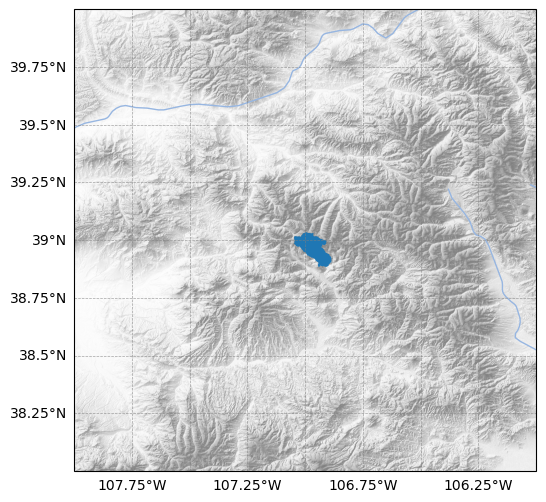

In [11]:
# Create the plot with Cartopy projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

east_river.plot(ax=ax)

# Generate terrain shading
ls = LightSource(azdeg=315, altdeg=45)  # Azimuth and altitude of the light source
shaded = ls.shade(elevation, cmap=cm.get_cmap("Greys"), vert_exag=1, blend_mode="overlay")

# Plot the shaded terrain
ax.imshow(
    shaded,
    extent=extent,  # Ensure extent matches the geographic bounds of the data
    transform=ccrs.PlateCarree(),
    origin="upper",
    alpha=0.5
)

# Add state outlines and coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor="black")
ax.add_feature(cfeature.RIVERS)
# Add gridlines with latitude and longitude labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gridlines.top_labels = False  # Disable top labels
gridlines.right_labels = False  # Disable right labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

ax.set_extent([-108, -106, 38, 40], crs=ccrs.PlateCarree())  # east riverish extent


### Notes

use pygeohydro package to add shapefile of East river bounds

add hillshade using py3dep within above package

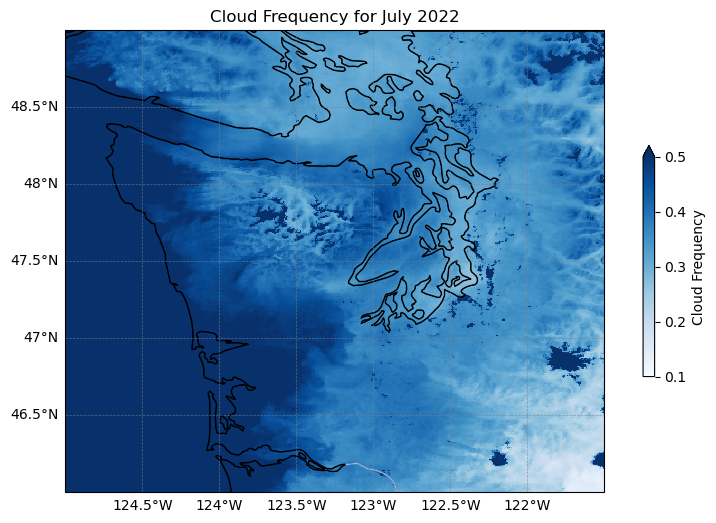

In [19]:
# Create the plot with Cartopy projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for geographic data

# Plot the data
jul_cloud_freq.monthly_frequency.plot(
    ax=ax, 
    cmap="Blues",  
    transform=ccrs.PlateCarree(),  # Specify the data's coordinate system
    cbar_kwargs={'label': 'Cloud Frequency', 'shrink': 0.5},
    vmin=0.1, vmax=0.5  # Set color scale limits
)

## plot east river bounds
# east_river.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=2, zorder=1, transform=ccrs.PlateCarree())

# # Generate terrain shading
# ls = LightSource(azdeg=315, altdeg=45)  # Azimuth and altitude of the light source
# shaded = ls.shade(elevation_data, cmap=cm.get_cmap("Greys"), vert_exag=1, blend_mode="overlay")

# # Plot the shaded terrain
# ax.imshow(
#     shaded,
#     extent=extent,  # Ensure extent matches the geographic bounds of the data
#     transform=ccrs.PlateCarree(),
#     origin="upper",
#     alpha=0.5
# )

# # Add elevation contours
# contour_levels = np.arange(1000, 4000, 250)  # Define contour levels (e.g., 1000m to 4000m)
# contour = ax.contour(
#     er_elevation, 
#     levels=contour_levels, 
#     colors='black', 
#     linewidths=0.8, 
#     transform=ccrs.PlateCarree(), 
#     extent=extent,
#     alpha=0.5  # Set transparency for contours
# )
# ax.clabel(contour, inline=True, fontsize=8, fmt='%d')  # Add labels to contours



# Add state outlines and coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor="black")
ax.add_feature(cfeature.RIVERS)
# Add gridlines with latitude and longitude labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gridlines.top_labels = False  # Disable top labels
gridlines.right_labels = False  # Disable right labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}


# Add title and labels
plt.title(f"Cloud Frequency for July 2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# ax.set_extent([-107.8, -106.4, 38.4, 39.5], crs=ccrs.PlateCarree())  # east riverish extent
ax.set_extent([-125, -121.5, 46, 49], crs=ccrs.PlateCarree()) # Western Washington

# Show the plot
plt.show()

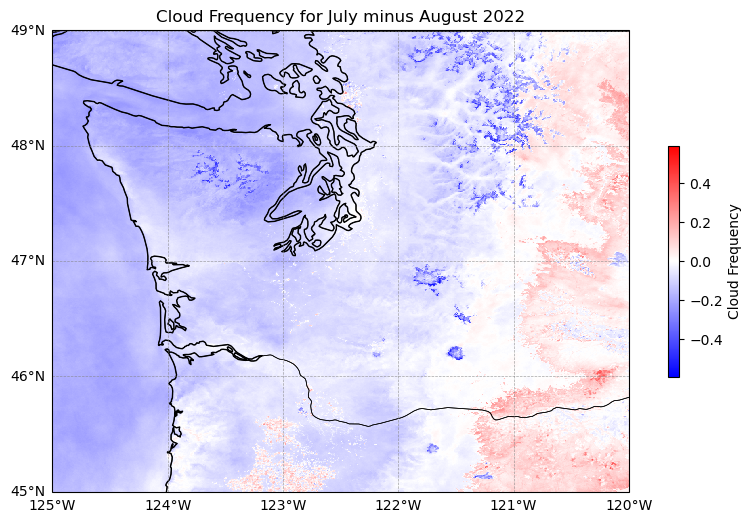

In [17]:
# Create the plot with Cartopy projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for geographic data

# Plot the cloud frequency data
aug_minus_jul.plot(
    ax=ax, 
    cmap="bwr",  
    transform=ccrs.PlateCarree(),  # Specify the data's coordinate system
    cbar_kwargs={'label': 'Cloud Frequency', 'shrink': 0.5}
)

# # plot east river bounds
# east_river.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=2, zorder=1, transform=ccrs.PlateCarree())


# # Add elevation contours
# contour_levels = np.arange(1000, 4000, 500)  # Define contour levels (e.g., 1000m to 4000m)
# elevation_masked = np.ma.masked_invalid(elevation)  # Mask invalid elevation values
# contour = ax.contour(
#     elevation_masked, 
#     levels=contour_levels, 
#     colors='black', 
#     linewidths=0.8, 
#     transform=ccrs.PlateCarree(), 
#     extent=extent,
#     alpha=0.5  # Set transparency for contours
# )
# ax.clabel(contour, inline=True, fontsize=8, fmt='%d')  # Add labels to contours


# Add state outlines and coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
# Add gridlines with latitude and longitude labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gridlines.top_labels = False  # Disable top labels
gridlines.right_labels = False  # Disable right labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}


# Add title and labels
plt.title(f"Cloud Frequency for July minus August 2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# ax.set_extent([-107.4, -106.4, 38.5, 39.5], crs=ccrs.PlateCarree())  # east riverish extent


# ax.text(-107.3, 39.4, 'East River Basin', fontsize=10, transform=ccrs.PlateCarree(), zorder=2)

# Show the plot
plt.show()